# Objective:

Apply LSTM on Amazon Food Review Dataset.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

C:\Users\ABHISEK\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [5]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string

In [12]:
import pickle
pickle_out = open("final_string.pickle","wb")
pickle.dump(final_string, pickle_out)
pickle_out.close()

In [11]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read these sendak book and watch the re...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'this fun way for children learn their month ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'this great littl book read has nice rhythm w...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'this book poetri about the month the year go...


In [12]:
X = final['CleanedText']
y = final['Score']

In [13]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Find top 5000 words 

In [14]:
dict1 = {}

for i in X_train:
    for j in i.decode('utf-8').split():
        if j in dict1:
            dict1[j] += 1
        else:
            dict1[j] = 1

In [15]:
sorted_by_value = sorted(dict1.items(), key=lambda x: x[1], reverse=True)

In [16]:
top_words = []
for k,v in sorted_by_value:
    top_words.append(k)

# creating train and test rows replacing words with indices

In [17]:
list2 = []
for i in X_train:
    list1 = []
    for j in i.decode('utf-8').split():
        if j in top_words[:5000]:
            list1.append(top_words[:5000].index(j))
        else:
            continue
    list2.append(list1)    

In [18]:
list3 = []
for i in X_test:
    list1 = []
    for j in i.decode('utf-8').split():
        if j in top_words[:5000]:
            list1.append(top_words[:5000].index(j))
        else:
            continue
    list3.append(list1)    

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [20]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

C:\Users\ABHISEK\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
# truncate and/or pad input sequences
max_review_length = 600
X_train1 = sequence.pad_sequences(list2, maxlen=max_review_length)
X_test1 = sequence.pad_sequences(list3, maxlen=max_review_length)

In [22]:
X_train1.shape

(254919, 600)

In [23]:
X_test1.shape

(109252, 600)

In [24]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
dict = {"positive" : '1', "negative" : '0'}
y_train =  y_train.map(dict)
y_test = y_test.map(dict)

In [36]:
history = model.fit(X_train1, y_train, nb_epoch=10, batch_size=64, validation_data=(X_test1, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test1, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\ABHISEK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 3746s 15ms/step - loss: 0.1296 - acc: 0.9504 - val_loss: 0.1408 - val_acc: 0.9462
Epoch 2/10
254919/254919 [==============================] - 3713s 15ms/step - loss: 0.1159 - acc: 0.9561 - val_loss: 0.1357 - val_acc: 0.9473
Epoch 3/10
254919/254919 [==============================] - 3750s 15ms/step - loss: 0.1052 - acc: 0.9596 - val_loss: 0.1375 - val_acc: 0.9472
Epoch 4/10
254919/254919 [==============================] - 3738s 15ms/step - loss: 0.0950 - acc: 0.9639 - val_loss: 0.1469 - val_acc: 0.9448
Epoch 5/10
254919/254919 [==============================] - 3764s 15ms/step - loss: 0.0863 - acc: 0.9673 - val_loss: 0.1448 - val_acc: 0.9472
Epoch 6/10
254919/254919 [==============================] - 3781s 15ms/step - loss: 0.0766 - acc: 0.9715 - val_loss: 0.1549 - val_acc: 0.9463
Epoch 7/10
254919/254919 [==============================] - 3824s 15ms/step - loss: 0.0687 - acc

<IPython.core.display.Javascript object>


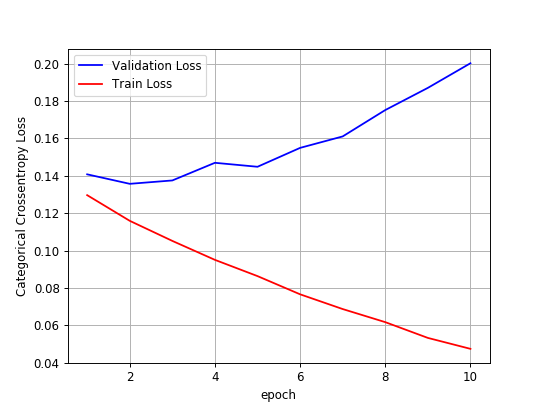

In [37]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
nb_epoch = 10
# list of epoch numbers
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [24]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
history = model.fit(X_train1, y_train, nb_epoch=10, batch_size=64, validation_data=(X_test1, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test1, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\ABHISEK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 254919 samples, validate on 109252 samples
Epoch 1/10
254919/254919 [==============================] - 9399s 37ms/step - loss: 0.2015 - acc: 0.9208 - val_loss: 0.1654 - val_acc: 0.9342
Epoch 2/10
254919/254919 [==============================] - 9996s 39ms/step - loss: 0.1431 - acc: 0.9445 - val_loss: 0.1398 - val_acc: 0.9454
Epoch 3/10
254919/254919 [==============================] - 9914s 39ms/step - loss: 0.1227 - acc: 0.9528 - val_loss: 0.1343 - val_acc: 0.9479
Epoch 4/10
254919/254919 [==============================] - 10844s 43ms/step - loss: 0.1098 - acc: 0.9577 - val_loss: 0.1355 - val_acc: 0.9477
Epoch 5/10
254919/254919 [==============================] - 10055s 39ms/step - loss: 0.0995 - acc: 0.9623 - val_loss: 0.1376 - val_acc: 0.9473
Epoch 6/10
254919/254919 [==============================] - 9891s 39ms/step - loss: 0.0901 - acc: 0.9660 - val_loss: 0.1427 - val_acc: 0.9481
Epoch 7/10
254919/254919 [==============================] - 10615s 42ms/step - loss: 0.0809 - 

<IPython.core.display.Javascript object>


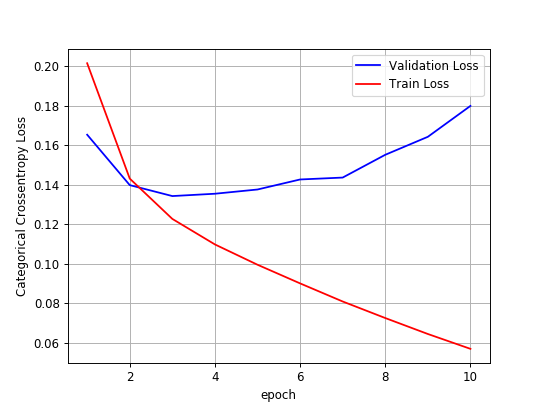

In [28]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
nb_epoch = 10
# list of epoch numbers
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion:   

In [29]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","test acuracy"]
x.add_row(["LSTM","94.08%"])
x.add_row(["Stacking two LSTM","94.47%"])

print(x)

+-------------------+--------------+
|       Model       | test acuracy |
+-------------------+--------------+
|        LSTM       |    94.08%    |
| Stacking two LSTM |    94.47%    |
+-------------------+--------------+
